## Imports

In [1]:
import os
import torch
import torch_sparse
from torch_sparse.tensor import SparseTensor
import torchsparsegradutils as tsgu
import math
from sklearn.model_selection import ParameterGrid
from bioplnn.utils import idx_2D_to_1D
from addict import Dict as AttrDict
from bioplnn.models import TopographicalRNN
from bioplnn.utils import get_mnist_v1_dataloaders
from bioplnn.sparse_sgd import SparseSGD
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'seaborn'

In [7]:
!nvidia-smi

Mon Jul  8 15:59:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:C3:00.0 Off |                    0 |
| N/A   38C    P0             70W /  300W |    1493MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Parameters

In [8]:
batch_size = 1
num_neurons = 100000
synapses_per_neuron = 100
torch.set_float32_matmul_precision("high")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sparsity: {1 - synapses_per_neuron / num_neurons:.2%}")
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Sparsity: 99.90%


In [22]:
# Create a dense vector
indices = []
for i in range(num_neurons):
    synapses = torch.randint(0, num_neurons, (synapses_per_neuron,))
    synapse_root = torch.ones_like(synapses) * i
    indices.append(torch.stack((synapses, synapse_root)))
indices = torch.cat(indices, dim=1).to(device)
values = torch.randn(num_neurons * synapses_per_neuron).to(device)

indices, values = torch_sparse.coalesce(indices, values, num_neurons, num_neurons)

coo_matrix = (
    torch.sparse_coo_tensor(indices, values, (num_neurons, num_neurons))
    .coalesce()
    .to(device)
)
csr_matrix = coo_matrix.to_sparse_csr().to(device)
spt_coo_matrix = SparseTensor.from_torch_sparse_coo_tensor(coo_matrix).to(device)
spt_csr_matrix = SparseTensor.from_torch_sparse_csr_tensor(csr_matrix).to(device)

# dense_matrix = coo_matrix.to_dense().to(device)
dense_vector_batched = torch.randn(num_neurons, batch_size).to(device)

## On GPU

### `requires_grad == False`

In [23]:
%timeit torch.sparse.mm(coo_matrix, dense_vector_batched)

350 µs ± 64.4 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
%timeit torch.sparse.mm(csr_matrix, dense_vector_batched)

158 µs ± 85.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
%timeit tsgu.sparse_mm(coo_matrix, dense_vector_batched)

350 µs ± 55.6 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
%timeit tsgu.sparse_mm(csr_matrix, dense_vector_batched)

159 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
%timeit torch_sparse.spmm(indices, values, num_neurons, num_neurons, dense_vector_batched)

781 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
%timeit spt_csr_matrix.spmm(dense_vector_batched)

991 µs ± 51.7 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
%timeit spt_coo_matrix.spmm(dense_vector_batched)

992 µs ± 187 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [37]:
# %timeit torch.mm(dense_matrix, dense_vector_batched)

24.4 ms ± 203 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
# sns.set(rc={"text.usetex": True})
times = [346, 158, 346, 159, 771, 24400]
labels = [
    "torch.sparse.mm (COO)",
    "torch.sparse.mm (CSR)",
    "tsgu.sparse_mm (COO)",
    "tsgu.sparse_mm (CSR)",
    "torch_sparse.spmm",
    "torch.mm (Dense)",
]
df = pd.DataFrame({"Time (µs)": times, "MM Function": labels})

/tmp/ipykernel_1486673/2567055162.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x="MM Function", y="Time (µs)", palette="flare")
/tmp/ipykernel_1486673/2567055162.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


Text(0.5, 1.0, 'Sparse and Dense Matrix Multiplication Function Times')

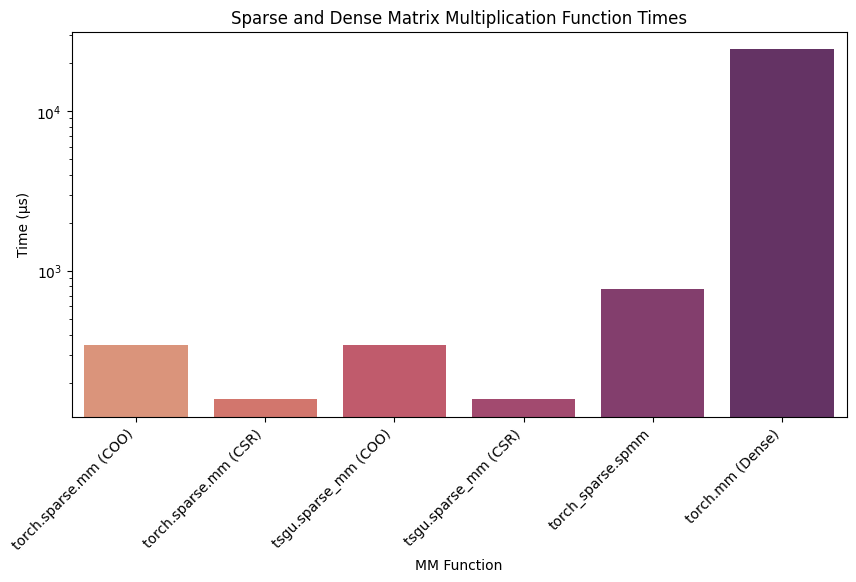

In [13]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df, x="MM Function", y="Time (µs)", palette="flare")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment="right",
)
ax.set_yscale("log")
plt.title("Sparse and Dense Matrix Multiplication Function Times")

/tmp/ipykernel_1486673/2581737512.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x="MM Function", y="Time (µs)", palette="flare")
/tmp/ipykernel_1486673/2581737512.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


Text(0.5, 1.0, 'Sparse Matrix Multiplication Function Times')

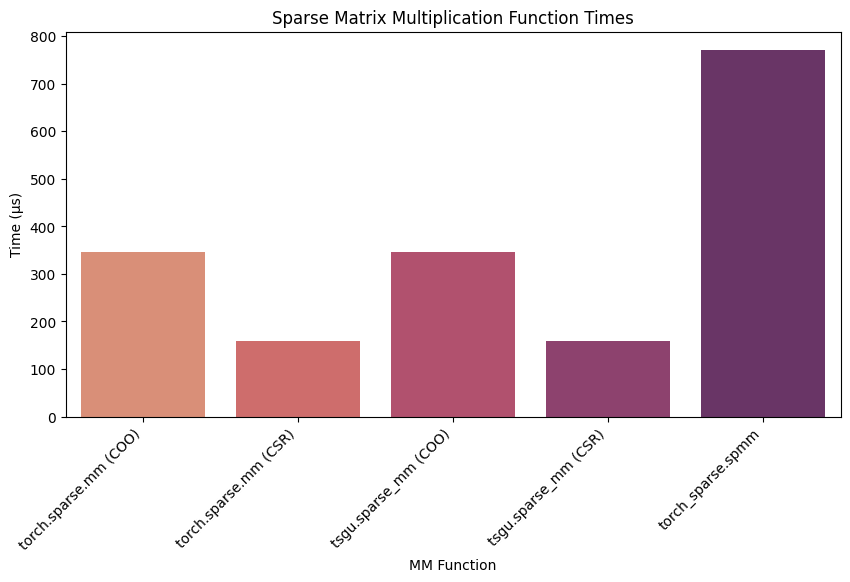

In [14]:
df = df.drop(df[df["MM Function"] == "torch.mm (Dense)"].index)
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df, x="MM Function", y="Time (µs)", palette="flare")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment="right",
)
plt.title("Sparse Matrix Multiplication Function Times")

### `requires_grad == True`

In [45]:
coo_weight = coo_matrix.clone().requires_grad_(True)
csr_weight = csr_matrix.clone().requires_grad_(True)
torch_sparse_weight = values.clone().requires_grad_(True)
spt_weight = spt_csr_matrix.clone().requires_grad_(True)
spt_value = spt_csr_matrix.storage.value()
# dense_weight = dense_matrix.clone().requires_grad_(True)

coo_optimizer = torch.optim.SGD([coo_weight], lr=0.01)
csr_optimizer = SparseSGD([csr_weight], lr=0.01)
torch_sparse_optimizer = torch.optim.SGD([torch_sparse_weight], lr=0.01)
spt_optimizer = torch.optim.SparseAdam([spt_value], lr=0.01)

In [8]:
torch.cuda.empty_cache()

In [46]:
%%timeit
out = torch.sparse.mm(csr_weight, dense_vector_batched)
csr_optimizer.zero_grad()
out.sum().backward()
csr_optimizer.step()

7.84 ms ± 589 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
%%timeit
out = torch_sparse.spmm(
    indices, torch_sparse_weight, num_neurons, num_neurons, dense_vector_batched
)
torch_sparse_optimizer.zero_grad()
out.sum().backward()
torch_sparse_optimizer.step()

1.03 ms ± 93.3 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
%%timeit
out = spt_weight.spmm(dense_vector_batched)
spt_optimizer.zero_grad()
out.sum().backward()
spt_optimizer.step()

3.29 ms ± 48.9 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [40]:
%%timeit
out = tsgu.sparse_mm(csr_weight, dense_vector_batched)
csr_optimizer.zero_grad()
out.sum().backward()
csr_optimizer.step()

13.3 ms ± 2.17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## On CPU

In [43]:
coo_matrix = coo_matrix.to("cpu")
csr_matrix = csr_matrix.to("cpu")
# dense_matrix = coo_matrix.to_dense().to("cpu")
dense_vector_batched = dense_vector_batched.to("cpu")
indices = indices.to("cpu")
values = values.to("cpu")

: 

In [28]:
%timeit torch.mm(coo_matrix, dense_vector_batched)

166 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit torch.mm(csr_matrix, dense_vector_batched)

10.1 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit torch.sparse.mm(coo_matrix, dense_vector_batched)

165 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit torch.sparse.mm(csr_matrix, dense_vector_batched)

9.7 ms ± 57.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit tsgu.sparse_mm(coo_matrix, dense_vector_batched)

166 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%timeit tsgu.sparse_mm(csr_matrix, dense_vector_batched)

9.65 ms ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
%timeit torch_sparse.spmm(indices, values, num_neurons, num_neurons, dense_vector_batched)

55.3 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
# %timeit torch.mm(dense_matrix, dense_vector_batched)